In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)

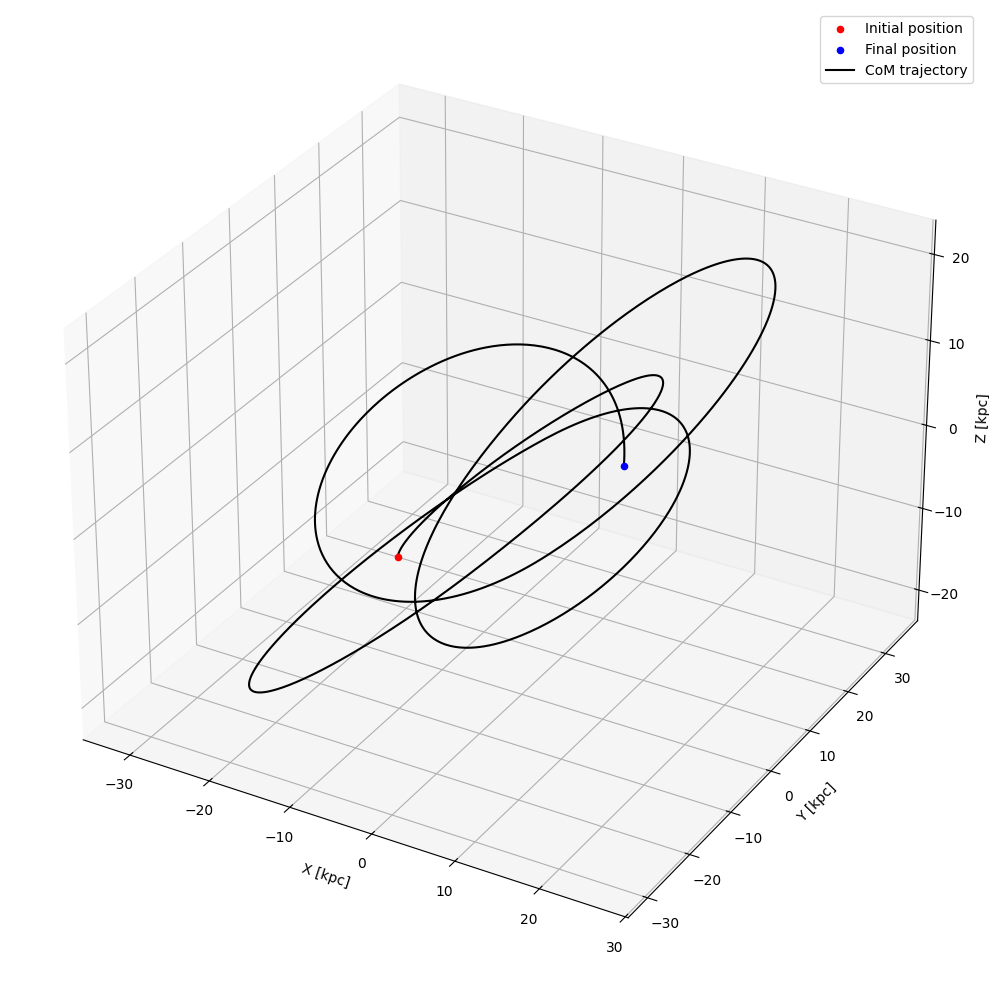

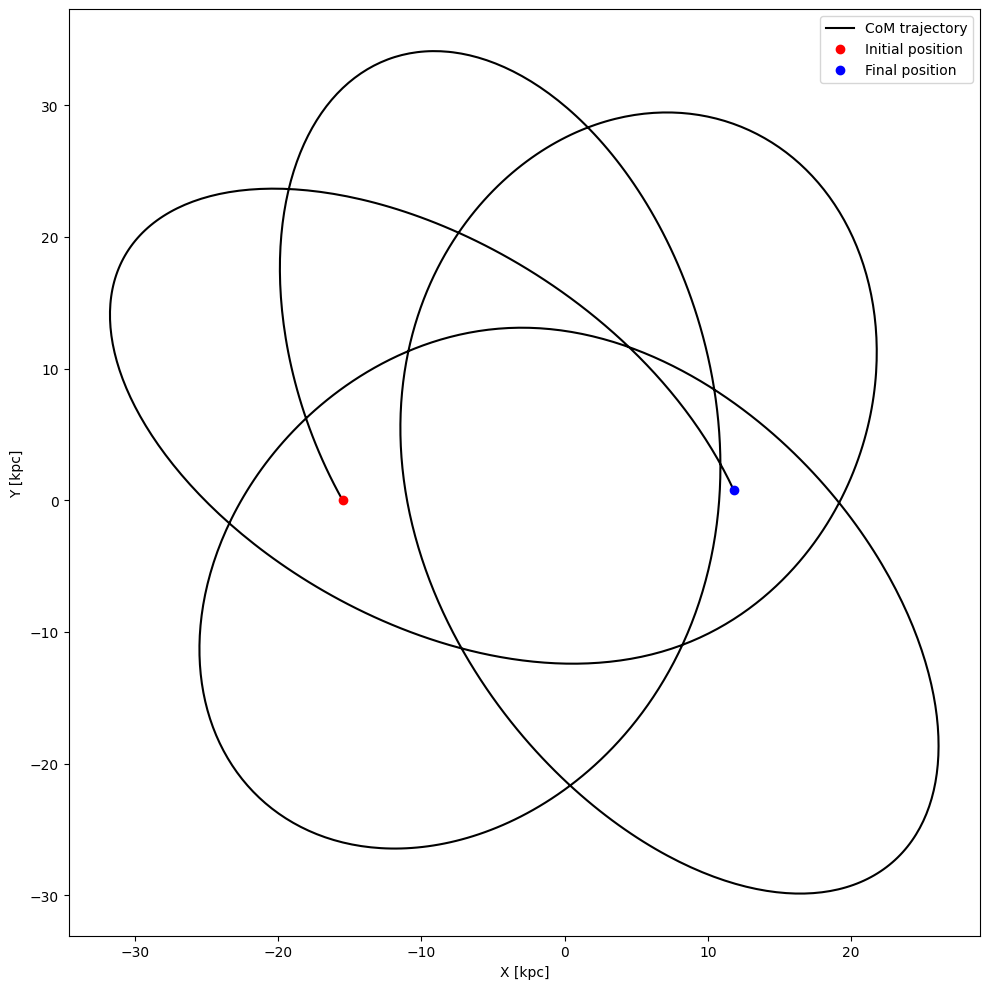

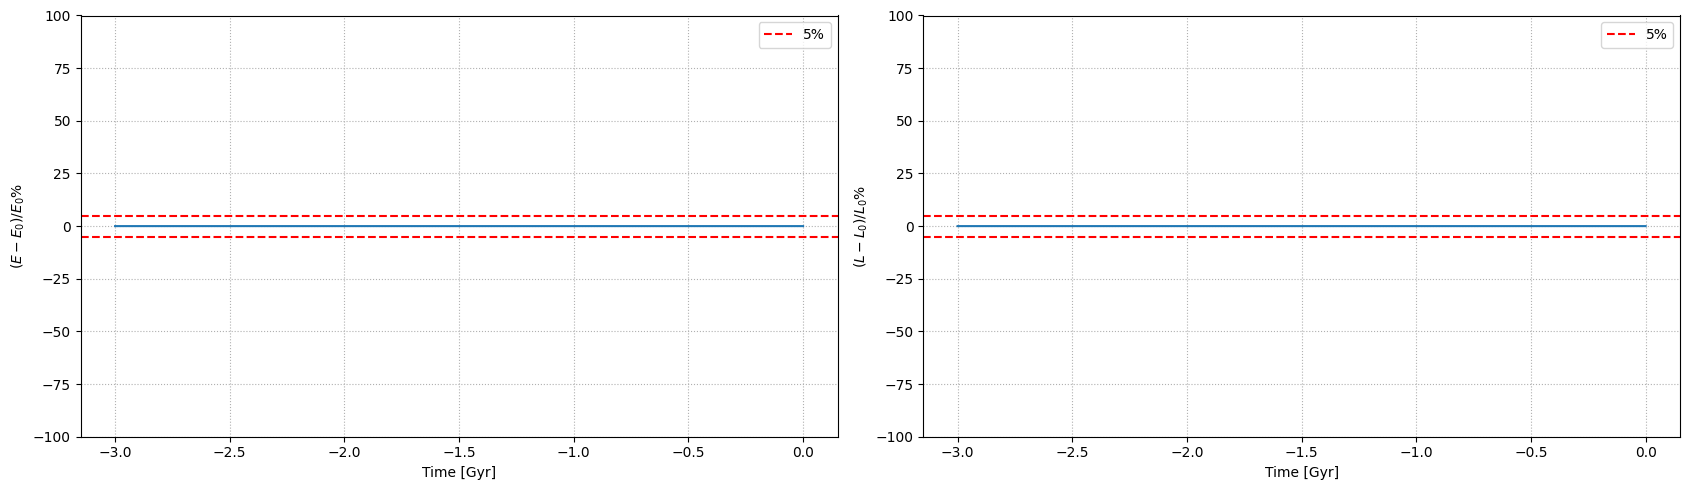

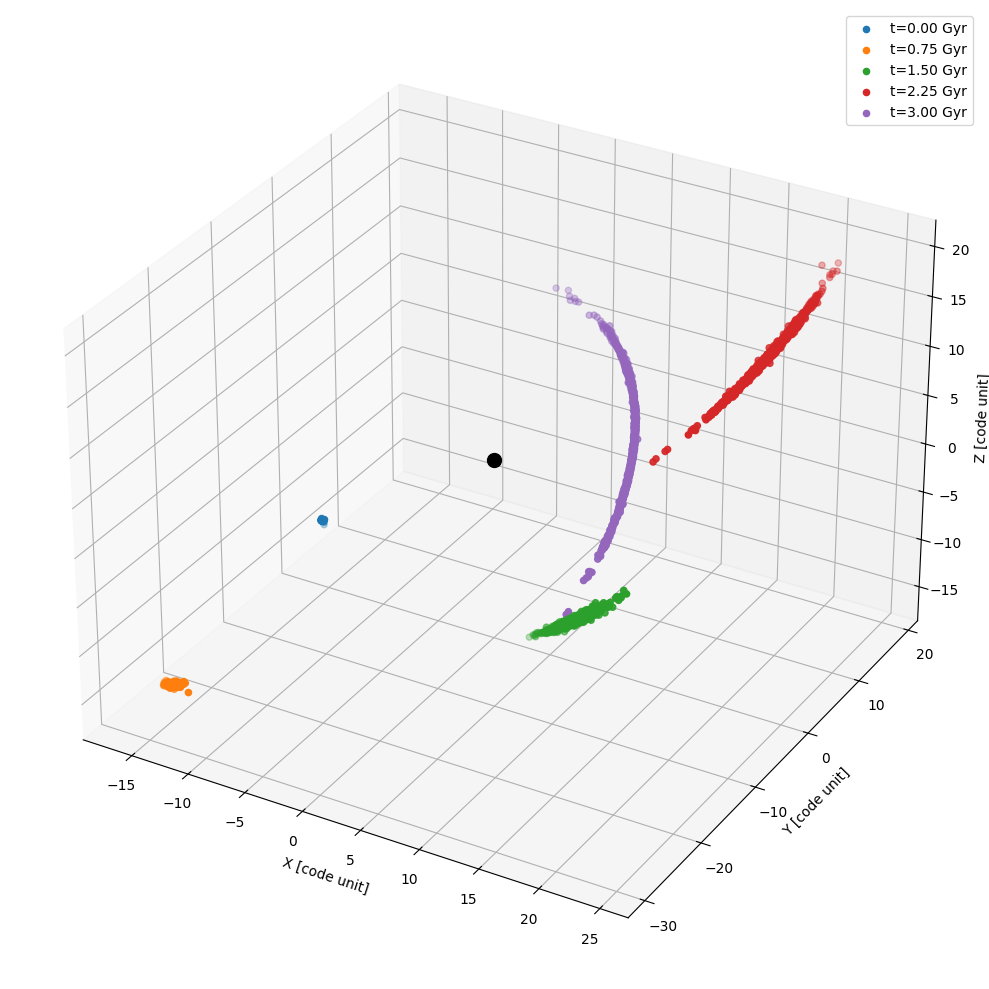

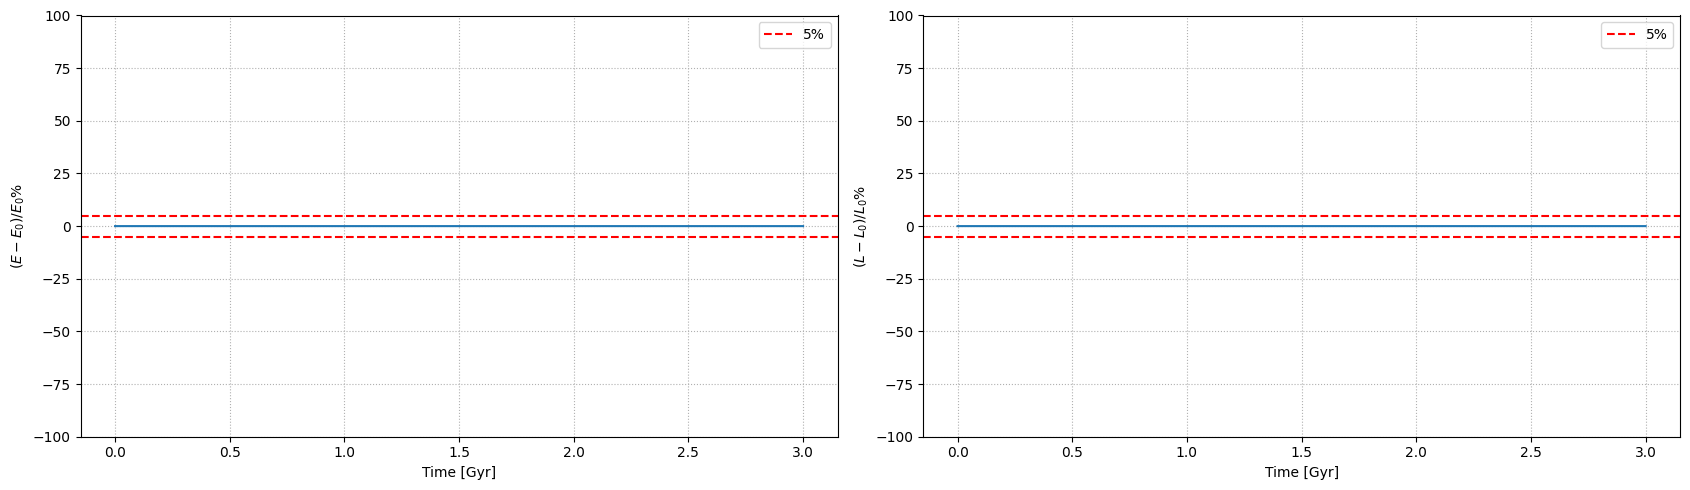

In [3]:
##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

##### Stream orbit plot####
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


In [4]:
config_com

SimulationConfig(N_particles=1, dimensions=3, return_snapshots=True, num_snapshots=1000, fixed_timestep=False, num_timesteps=1000, softening=np.float64(1.0000000000000003e-05), integrator=2, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(0, 2, 3), differentation_mode=1, num_checkpoints=100, progress_bar=False, gradient_horizon=0)

In [5]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 1000, 
#                          softening = (0.1 * u.pc).to(code_units.code_length).value,
#                          )

config_com = config_com._replace(return_snapshots=True,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )



@jit
def time_integration_NFW_mass_grad(Mvir,):

    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com_backward = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ), t_end = - 0.2 * u.Gyr.to(code_units.code_time),)
    new_params_com_forward = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ), t_end = 0.2 * u.Gyr.to(code_units.code_time),)
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(Mvir, t_end):
        new_params = params._replace(
                    NFW_params=params.NFW_params._replace(
                        Mvir=Mvir 
                    ), t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    Mvir_array = jnp.array([Mvir, Mvir])
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(Mvir_array, t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    #mask the data to select only the part of the stream that is close to the observed data
    #this is done to avoid the problem of the stream wrapping around the sky
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1]<phi1_max)&(stream_coordinate_com_backward[:, 0, 1]>phi1_min)&(stream_coordinate_com_backward[:, 0, 2]<phi2_max)&(stream_coordinate_com_backward[:, 0, 2]>phi2_min)
    mask_diff_backward = (jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1)>0)
    mask_backward = (stream_data[:, 1]>stream_coordinate_com_backward[0, :, 1])&(mask_window_backward)&(mask_diff_backward)

    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1]<phi1_max)&(stream_coordinate_com_forward[:, 0, 1]>phi1_min)&(stream_coordinate_com_forward[:, 0, 2]<phi2_max)&(stream_coordinate_com_forward[:, 0, 2]>phi2_min)
    mask_diff_forward = (jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=1)<0)
    mask_forward = (stream_data[:, 1]<stream_coordinate_com_forward[0, :, 1])&(mask_window_forward)&(mask_diff_forward)

    # @partial(jit, static_argnames=['backward'])
    # def chi2_with_masking(stream_coordinate_com, backward):
    #     if backward:
    #         mask = mask_backward
    #     else:
    #         mask = mask_forward
        
    #     interpolated_stream_track = jnp.where(mask, jnp.interp(stream_data[:, 1], stream_coordinate_com[:, :, 1].ravel(), stream_coordinate_com[:, :, 2].ravel()), jnp.nan)
    #     chi2 = jnp.nansum((stream_data[:, 2] - interpolated_stream_track)**2 / 0.1**2)
    #     return chi2
    
    # chi2 = jax.vmap(chi2_with_masking)(stream_coordinate_com, jnp.array([True, False]))
    @jit
    def chi2_with_masking(stream_coordinate_com, backward):
        # Use jnp.where instead of if/else for JAX compatibility
        mask = jnp.where(backward, mask_backward, mask_forward)
        
        interpolated_stream_track = jnp.where(
            mask, 
            jnp.interp(stream_data[:, 1], stream_coordinate_com[:, :, 1].ravel(), stream_coordinate_com[:, :, 2].ravel()), 
            jnp.nan
        )
        chi2 = jnp.nansum((stream_data[:, 2] - interpolated_stream_track)**2 / 0.1**2)
        return chi2

    chi2 = jax.vmap(chi2_with_masking)(stream_coordinate_com, jnp.array([True, False]))
    chi2 = jnp.sum(chi2)

    #interpolate the stream track and calculate the chi2 only on the masked data
    # interp_stream_track = jnp.interp(stream_data[:, 1], stream_coordinate_com_backward[:, :, 1].ravel(), stream_coordinate_com_backward[:, :, 2].ravel())
    # interp_stream_track_forward = jnp.interp(stream_data[:, 1], stream_coordinate_com_forward[:, :, 1].ravel(), stream_coordinate_com_forward[:, :, 2].ravel())
    # chi2_forward = jnp.sum((jnp.where(mask_forward, stream_data[:, 2] - interp_stream_track_forward, 0))**2 / 0.1**2)
    # chi2_backward = jnp.sum((jnp.where(mask_backward, stream_data[:, 2] - interp_stream_track, 0))**2 / 0.1**2)

    # print(chi2, chi2_forward + chi2_backward)


    return stream_coordinate_com_backward, stream_coordinate_com_forward, chi2


stream_coordinate_com_backward, stream_coordinate_com_forward, chi = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir*0.1)




In [6]:
chi

Array(178648.25, dtype=float32)

In [7]:
stream_coordinate_com_backward.shape

(1000, 1, 6)

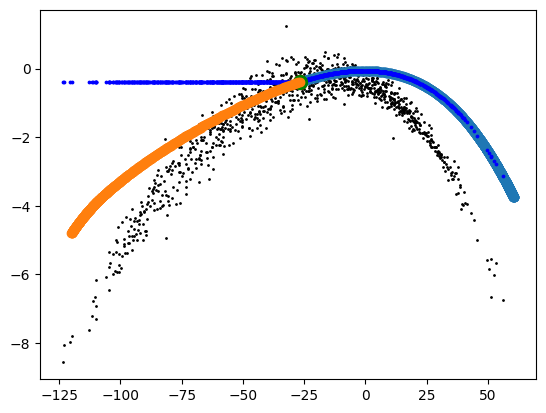

In [8]:
phi1_min, phi1_max = -120, 70
phi2_min, phi2_max = -8, 2
mask_window_backward = (stream_coordinate_com_backward[:, 0, 1]<phi1_max)&(stream_coordinate_com_backward[:, 0, 1]>phi1_min)&(stream_coordinate_com_backward[:, 0, 2]<phi2_max)&(stream_coordinate_com_backward[:, 0, 2]>phi2_min)
mask_diff_backward = (jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1)>0)
interp_backward = jnp.interp(stream_data[:, 1], stream_coordinate_com_backward[:, :, 1].ravel(), stream_coordinate_com_backward[:, :, 2].ravel())

mask_window_forward = (stream_coordinate_com_forward[:, 0, 1]<phi1_max)&(stream_coordinate_com_forward[:, 0, 1]>phi1_min)&(stream_coordinate_com_forward[:, 0, 2]<phi2_max)&(stream_coordinate_com_forward[:, 0, 2]>phi2_min)
mask_diff_forward = (jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1)<0)
stream_coordinate_com_backward = stream_coordinate_com_backward[mask_window_backward&mask_diff_backward]
stream_coordinate_com_forward = stream_coordinate_com_forward[mask_window_forward&mask_diff_forward]

plt.scatter(stream_data[:, 1], stream_data[:, 2], s=1, c='k')
plt.scatter(stream_coordinate_com_backward[0, 0, 1], stream_coordinate_com_backward[0, 0, 2], s=100, c='r')
plt.scatter(stream_coordinate_com_backward[:, :, 1], stream_coordinate_com_backward[:, :, 2], )
plt.scatter(stream_data[:, 1], interp_backward, s=3, c='b')

plt.scatter(stream_coordinate_com_forward[0, 0, 1], stream_coordinate_com_forward[0, 0, 2], s=100, c='g')
plt.scatter(stream_coordinate_com_forward[:, :, 1], stream_coordinate_com_forward[:, :, 2], )

# interp_stream_track = jnp.interp(stream_data[:, 1][stream_data[:, 1]>states_com_backward[0, :, 1]], states_com_backward[:50, :, 1].ravel(), states_com_backward[:50, :, 2].ravel())
# plt.scatter(stream_data[:, 1][stream_data[:, 1]>states_com_backward[0, :, 1]], interp_stream_track, s=3, c='b')

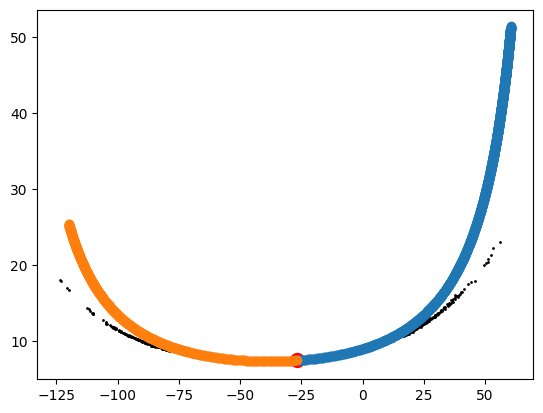

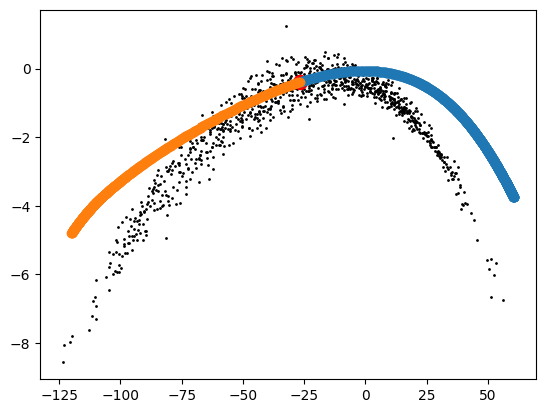

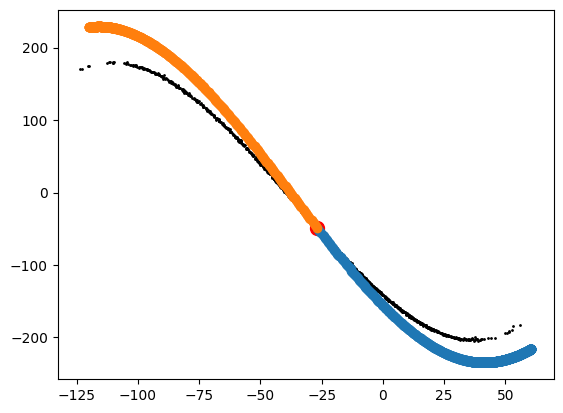

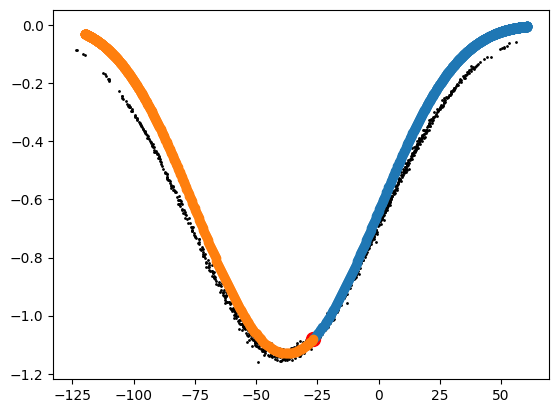

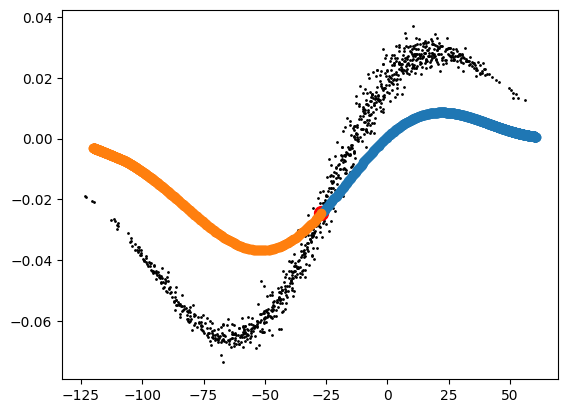

In [9]:
for i in [0, 2, 3, 4, 5]:
    plt.scatter(stream_data[:, 1], stream_data[:, i], s=1, c='k')
    plt.scatter(stream_coordinate_com_backward[0, :, 1], stream_coordinate_com_backward[0, :, i], s=100, c='r')
    plt.scatter(stream_coordinate_com_backward[:, :, 1], stream_coordinate_com_backward[:, :, i], )
    plt.scatter(stream_coordinate_com_forward[:, :, 1], stream_coordinate_com_forward[:, :, i], )
    plt.show()

# Fit only the phi2

In [10]:
@jit
def time_integration_NFW_mass_grad(Mvir,):

    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com_backward = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ), t_end = - 0.2 * u.Gyr.to(code_units.code_time),)
    new_params_com_forward = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ), t_end = 0.2 * u.Gyr.to(code_units.code_time),)
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(Mvir, t_end):
        new_params = params._replace(
                    NFW_params=params.NFW_params._replace(
                        Mvir=Mvir 
                    ), t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    Mvir_array = jnp.array([Mvir, Mvir])
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(Mvir_array, t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   jnp.nan)
    phi2_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 2], 
                                   jnp.nan)
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  jnp.nan)
    phi2_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 2], 
                                  jnp.nan)

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    # Interpolate for all stream data points
    interp_backward_all = jnp.interp(stream_data[:, 1], phi1_backward_valid, phi2_backward_valid)
    interp_forward_all = jnp.interp(stream_data[:, 1], phi1_forward_valid, phi2_forward_valid)
    
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  stream_data[:, 2] - interp_backward_all, 
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 stream_data[:, 2] - interp_forward_all, 
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) / 0.5**2
    chi2_forward = jnp.sum(residuals_forward**2) / 0.5**2
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward
    
    return chi2



chi2 = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir*0.1)

In [11]:
chi2

Array(13395.678, dtype=float32)

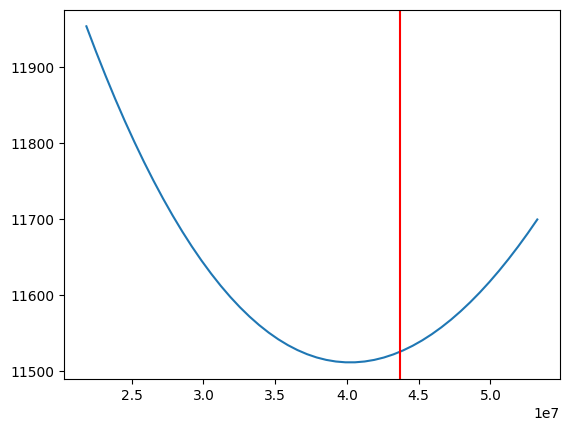

In [12]:
Mvir = jnp.linspace(params.NFW_params.Mvir*0.5, params.NFW_params.Mvir*2, 99)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir)
plt.plot(Mvir, chi2)
plt.axvline(params.NFW_params.Mvir, color='r')
# plt.ylim(-100000, 100000)

In [160]:
grad

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

# Fit everythig

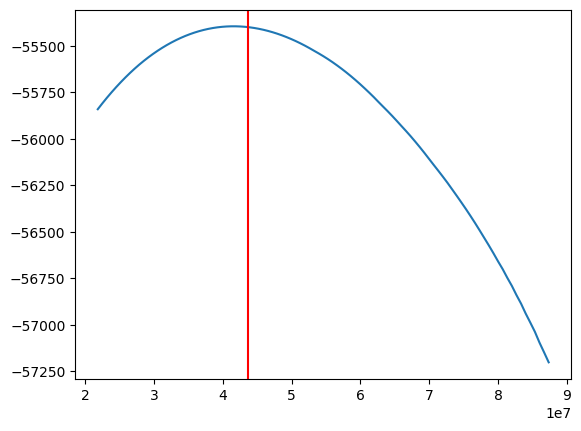

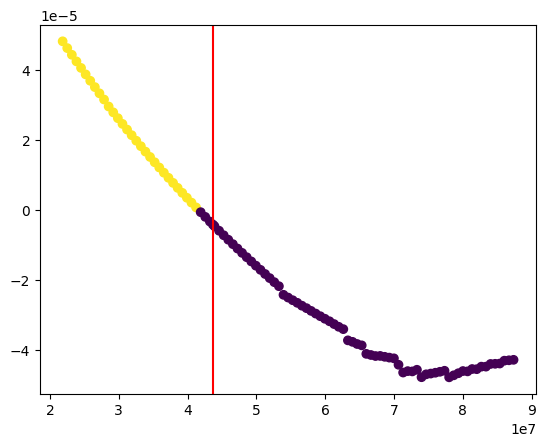

In [11]:
@partial(jit, static_argnames=['coord_indices'])
def time_integration_NFW_mass_grad(Mvir,coord_indices=jnp.array([2, 3, 4, 5])):

    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(Mvir, t_end):
        new_params = params._replace(
                    NFW_params=params.NFW_params._replace(
                        Mvir=Mvir 
                    ), t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.1 * u.Gyr.to(code_units.code_time)
    Mvir_array = jnp.array([Mvir, Mvir])
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(Mvir_array, t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   100000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  100000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_forward_valid, 
            coord_forward_valid
        )

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
 
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward) + jnp.sum(mask_stream_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood


log_likelihood = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir*0.1)
Mvir = jnp.linspace(params.NFW_params.Mvir*0.5, params.NFW_params.Mvir*2, 99)
Mvir = jnp.append(Mvir, jnp.array([params.NFW_params.Mvir]))
Mvir = jnp.sort(Mvir)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir)
plt.plot(Mvir, chi2)
plt.axvline(params.NFW_params.Mvir, color='r')
plt.show()
plt.scatter(Mvir, grad, c=grad>0)
plt.axvline(params.NFW_params.Mvir, color='r')


# R_s

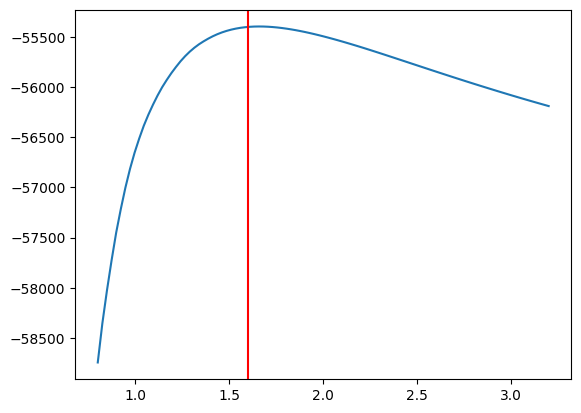

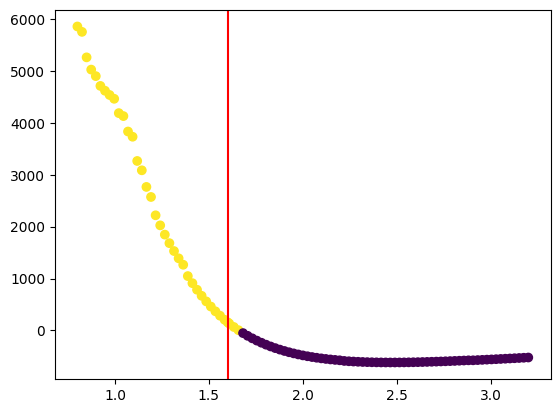

In [227]:
@partial(jit, static_argnames=['coord_indices'])
def time_integration_r_s_grad(r_s,coord_indices=jnp.array([2, 3, 4, 5])):

    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(r_s, t_end):
        new_params = params._replace(
                    NFW_params=params.NFW_params._replace(
                        r_s=r_s
                    ), t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.1 * u.Gyr.to(code_units.code_time)
    r_s_array = jnp.array([r_s, r_s])
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(r_s_array, t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   100000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  100000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_forward_valid, 
            coord_forward_valid
        )

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
 
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward) + jnp.sum(mask_stream_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood


log_likelihood = time_integration_r_s_grad(r_s=params.NFW_params.r_s*0.1)
r_s = jnp.linspace(params.NFW_params.r_s*0.5, params.NFW_params.r_s*2, 99)
r_s = jnp.append(r_s, jnp.array([params.NFW_params.r_s]))
r_s = jnp.sort(r_s)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_r_s_grad))(r_s)
plt.plot(r_s, chi2)
plt.axvline(params.NFW_params.r_s, color='r')
plt.show()
plt.scatter(r_s, grad, c=grad>0)
plt.axvline(params.NFW_params.r_s, color='r')


# M_MN

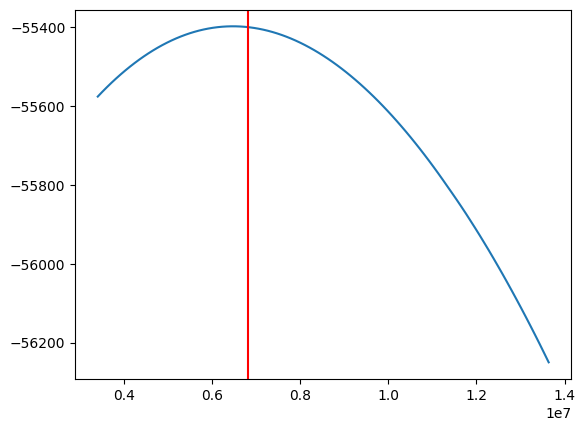

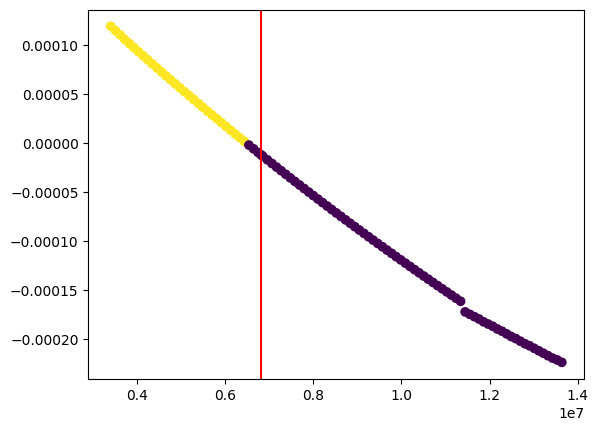

In [ ]:
@partial(jit, static_argnames=['coord_indices'])
def time_integration_MN_mass_grad(M_MN, coord_indices=jnp.array([2, 3, 4, 5])):

    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(M_MN, t_end):
        new_params = params._replace(
                    MN_params=params.MN_params._replace(
                        M=M_MN
                    ), t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.1 * u.Gyr.to(code_units.code_time)
    M_MN_array = jnp.array([M_MN, M_MN])
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(M_MN_array, t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   100000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  100000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_forward_valid, 
            coord_forward_valid
        )

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
 
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward) + jnp.sum(mask_stream_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood


log_likelihood = time_integration_MN_mass_grad(M_MN=params.MN_params.M*0.1)
M_MN = jnp.linspace(params.MN_params.M*0.5, params.MN_params.M*2, 99)
M_MN = jnp.append(M_MN, jnp.array([params.MN_params.M]))
M_MN = jnp.sort(M_MN)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_MN_mass_grad))(M_MN)
plt.plot(M_MN, chi2)
plt.axvline(params.MN_params.M, color='r')
plt.show()
plt.scatter(M_MN, grad, c=grad>0)
plt.axvline(params.MN_params.M, color='r')


# a MN

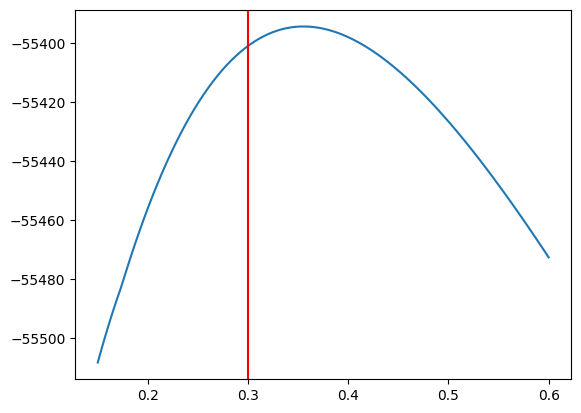

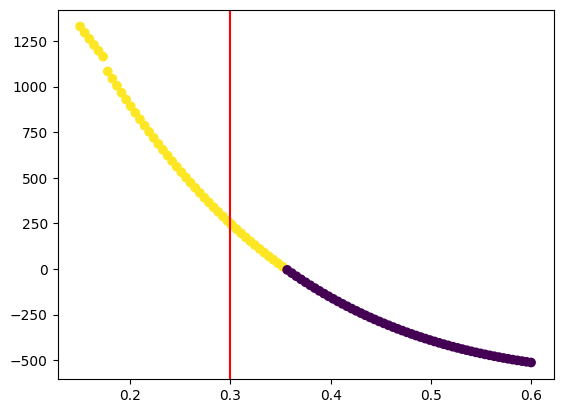

In [228]:
@partial(jit, static_argnames=['coord_indices'])
def time_integration_a_MN_grad(a_MN, coord_indices=jnp.array([2, 3, 4, 5])):

    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(a_MN, t_end):
        new_params = params._replace(
                    MN_params=params.MN_params._replace(
                        a=a_MN
                    ), t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.1 * u.Gyr.to(code_units.code_time)
    a_MN_array = jnp.array([a_MN, a_MN])
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(a_MN_array, t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   100000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  100000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_forward_valid, 
            coord_forward_valid
        )

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
 
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward) + jnp.sum(mask_stream_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood


log_likelihood = time_integration_a_MN_grad(a_MN=params.MN_params.a*0.1)
a_MN = jnp.linspace(params.MN_params.a*0.5, params.MN_params.a*2, 99)
a_MN = jnp.append(a_MN, jnp.array([params.MN_params.a]))
a_MN = jnp.sort(a_MN)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_a_MN_grad))(a_MN)
plt.plot(a_MN, chi2)
plt.axvline(params.MN_params.a, color='r')
plt.show()
plt.scatter(a_MN, grad, c=grad>0)
plt.axvline(params.MN_params.a, color='r')


# MCMC

In [6]:
params

SimulationParams(G=np.float64(0.00040486519363225977), t_end=np.float64(1.0), Plummer_params=PlummerParams(a=np.float64(0.0008000000000000001), Mtot=np.float64(3.1622776601683795)), NFW_params=NFWParams(Mvir=np.float64(43683325.0), r_s=np.float64(1.6)), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=np.float64(6819390.2782346755), a=np.float64(0.30000000000000004), b=np.float64(0.028000000000000004)), PSP_params=PSPParams(M=450136.537506545, alpha=1.8, r_c=np.float64(0.19)), Logarithmic_params=LogarithmicParams(v0=220.0, q=0.9))

In [18]:
import jax.numpy as jnp
import jax
from jax import jit


import pandas as pd

from chainconsumer import Chain, ChainConsumer, Truth


import blackjax
from tqdm import tqdm

params_sim = params

# ----------------------------- Load observation & precompute target densities ----------------
true_GD1_observation_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/true.npz'
_obs = np.load(true_GD1_observation_path)
stream_data = jnp.array(_obs['x']).reshape(1000, 6)  # will be used only to compute target densities
true_theta = jnp.array(_obs['theta'])


@jit
def run_simulation(params):

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        new_params = params_sim._replace(
                        NFW_params=params_sim.NFW_params._replace(
                            Mvir = params['M_NFW']*u.Msun.to(code_units.code_mass),
                            r_s = params['r_s']*u.kpc.to(code_units.code_length),),
                        MN_params=params_sim.MN_params._replace(
                            M = params['M_MN']*u.Msun.to(code_units.code_mass),
                            a = params['a_MN']*u.kpc.to(code_units.code_length),),
                        t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.1 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)

    return stream_coordinate_com


@jit
def stream_loglikelihood(stream_coordinate_com, ):
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]
    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   100000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  100000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    
    coord_indices=jnp.array([2, 3, 4, 5])

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_forward_valid, 
            coord_forward_valid
        )

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)

    #
    sigma = jnp.array([0.5, 10., 2., 2. ]) 
 
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward) + jnp.sum(mask_stream_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood
    
    
@jit
def evaluate_loglikelihood(theta_1, ):

        # print(f"In the corrector: theta_1 shape: {theta_1.shape}, target shape: {target.shape}")
        output = run_simulation(theta_1)

        # return stream_likelihood(model_stream=output, obs_stream=observation, obs_errors=jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001]))
        return stream_loglikelihood(stream_coordinate_com=output, )

# True parameter values (without code_units transformation)
true_params = jnp.array([
    4.3683325e11,          # NFW Mvir (Msun)
    16.0,                  # NFW r_s (kpc)
    68_193_902_782.346756, # MN M (Msun)
    3.0,                   # MN a (kpc)
])

# Prior bounds for each parameter
prior_bounds = jnp.array([
    [4.3683325e11 * 0.25, 4.3683325e11 * 2.0],  # NFW Mvir: 1/4 to 2x true
    [16.0 * 0.25, 16.0 * 2.0],    # NFW r_s: 1/4 to 2x true (kpc)
    [68_193_902_782.346756 * 0.25, 68_193_902_782.346756 * 2.0],  # MN M: 1/4 to 2x true
    [3.0 * 0.25, 3.0 * 2.0],      # MN a: 1/4 to 2x true (kpc)
])  # Shape: (7, 2) for [min, max] bounds

def draw_from_prior(key):
    """Draw samples from uniform prior."""
    key, subkey = jax.random.split(key)
    u = jax.random.uniform(subkey, shape=(4,))
    
    # Transform uniform [0,1] to [min, max] for each parameter
    samples = prior_bounds[:, 0] + u * (prior_bounds[:, 1] - prior_bounds[:, 0])
    samples = {'M_NFW': samples[0], 'r_s': samples[1], 'M_MN': samples[2], 'a_MN': samples[3]}
    return samples

param_order = ['M_NFW', 'r_s', 'M_MN', 'a_MN']
@jit
def dict_to_array(theta_dict):
    return jnp.array([theta_dict[k] for k in param_order])

@jit
def array_to_dict(theta_array):
    return {k: theta_array[i] for i, k in enumerate(param_order)}

@jit
def evaluate_log_prior(theta):
    """Evaluate log prior density (uniform)."""
    # Check if all parameters are within bounds 
    # theta = jnp.array([theta['t_end'], theta['Mtot'], theta['a_Plummer'], theta['M_NFW'], theta['r_s'], theta['M_MN'], theta['a_MN']])
    # in_bounds = jnp.all((theta >= prior_bounds[:, 0]) & (theta <= prior_bounds[:, 1])) 
    in_bounds = jnp.all(jnp.array([
        (theta['M_NFW'] >= prior_bounds[0, 0]) & (theta['M_NFW'] <= prior_bounds[0, 1]),
        (theta['r_s'] >= prior_bounds[1, 0]) & (theta['r_s'] <= prior_bounds[1, 1]),
        (theta['M_MN'] >= prior_bounds[2, 0]) & (theta['M_MN'] <= prior_bounds[2, 1]),
        (theta['a_MN'] >= prior_bounds[3, 0]) & (theta['a_MN'] <= prior_bounds[3, 1]),
    ]))
    
    # For uniform distribution: log(density) = -log(volume)
    # Volume = product of interval widths
    log_volume = jnp.sum(jnp.log(prior_bounds[:, 1] - prior_bounds[:, 0]))
    
    # Return -inf if out of bounds, -log_volume if in bounds
    return jnp.where(in_bounds, -log_volume, -jnp.inf)
    # return -log_volume


def draw_from_proposal(key, theta, sigma2_prop):
    key, sk = jax.random.split(key)
    theta_prime = jax.random.normal(sk, shape=theta.shape) * jnp.sqrt(sigma2_prop) + theta
    return theta_prime, key

@jit
def evaluate_log_posterior_grad(theta):
    """Compute gradient of log posterior."""
    
    def log_posterior(theta):
        log_prior = evaluate_log_prior(theta)
        log_like = evaluate_loglikelihood(theta)
        return log_prior + log_like
    
    # Get both value and gradient
    log_post_val, grad = jax.value_and_grad(log_posterior)(theta)
    return log_post_val, grad

@jit
def evaluate_log_posterior(theta):
    log_prior = evaluate_log_prior(theta)
    log_like = evaluate_loglikelihood(theta_1 = theta, )
    return log_prior + log_like

In [19]:
posterior_SBI = np.load('../../../../sbi_diff_sim/sbi-sim/logs/OdisseoCrossAttentionSetTransformer_small_AllParameters_Position_uniforprior_2e5_TSIT5/pictures/predicted_theta_test_set.npz')['predicted_theta'][0]
mean = np.mean(posterior_SBI, axis=0)
init_positions = mean[[3, 4, 5, 6]] 
init_positions[[0, 2]] = 10**init_positions[[0, 2]]
init_positions = array_to_dict(init_positions)
evaluate_log_posterior(init_positions)

Array(-55884.53, dtype=float32)

In [20]:
# Fix: Create a proper random step function instead of passing an array
def random_step_fn(rng_key, position):
    """Generate random step proposals for each parameter."""

    step_sizes = jnp.array([
        1e11,    # M_NFW (Msun) - large steps for large values  
        10.0,    # r_s (kpc)
        1e11,    # M_MN (Msun) - large steps for large values
        1,    # a_MN (kpc)
    ])
    
    # Generate random steps
    random_steps = jax.random.normal(rng_key, shape=(4,)) * 0.1 * step_sizes

    # Convert to dictionary format to match your position format
    step_dict = {
        'M_NFW': random_steps[0],
        'r_s': random_steps[1],
        'M_MN': random_steps[2],
        'a_MN': random_steps[3]
    }
    return step_dict


# Build the kernel
rmh = blackjax.additive_step_random_walk(
    logdensity_fn=evaluate_log_posterior,
    random_step=random_step_fn
)

# Initialize the state
# Initialize the state
posterior_SBI = np.load('../../../../sbi_diff_sim/sbi-sim/logs/OdisseoCrossAttentionSetTransformer_small_AllParameters_Position_uniforprior_2e5_TSIT5/pictures/predicted_theta_test_set.npz')['predicted_theta'][0]
mean = np.mean(posterior_SBI, axis=0)
init_positions = mean[[3, 4, 5, 6]]
init_positions[[0, 2]] = 10**init_positions[[0, 2]]
init_positions = array_to_dict(init_positions)
state = rmh.init(init_positions)


from blackjax.util import run_inference_algorithm

final_state, history_state = run_inference_algorithm(
    rng_key=jax.random.PRNGKey(0),
    inference_algorithm=rmh,
    num_steps=2_000,
    initial_state=state,
    progress_bar=True,
)

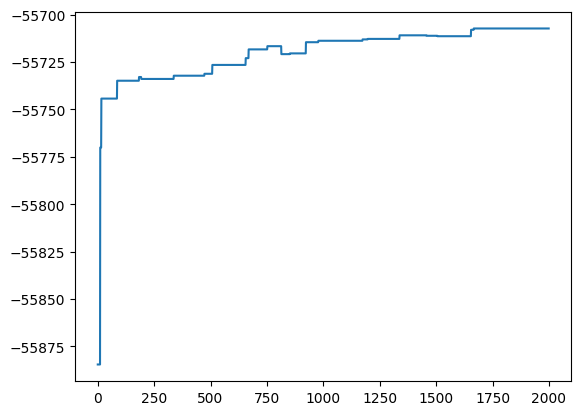

In [26]:
plt.plot(history_state[0].logdensity)

In [27]:
history_state

(RWState(position={'M_MN': Array([8.0288555e+10, 8.0288555e+10, 8.0288555e+10, ..., 1.0218494e+11,
        1.0218494e+11, 1.0218494e+11], dtype=float32), 'M_NFW': Array([5.3141465e+11, 5.3141465e+11, 5.3141465e+11, ..., 6.1070842e+11,
        6.1070842e+11, 6.1070842e+11], dtype=float32), 'a_MN': Array([3.6173007, 3.6173007, 3.6173007, ..., 4.37555  , 4.37555  ,
        4.37555  ], dtype=float32), 'r_s': Array([20.5701  , 20.5701  , 20.5701  , ..., 22.481855, 22.481855,
        22.481855], dtype=float32)}, logdensity=Array([-55884.53 , -55884.53 , -55884.53 , ..., -55707.297, -55707.297,
        -55707.297], dtype=float32)),
 RWInfo(acceptance_rate=Array([0.0000000e+00, 0.0000000e+00, 1.5521287e-25, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32), is_accepted=Array([False, False, False, ..., False, False, False], dtype=bool), proposal=RWState(position={'M_MN': Array([8.0288555e+10, 8.0288555e+10, 8.0288555e+10, ..., 1.0218494e+11,
        1.0218494e+11, 1.0218

In [28]:
RWState = history_state[0]
positions = RWState.position
df = pd.DataFrame(positions)

In [29]:
df

,M_MN,M_NFW,a_MN,r_s
0,8.028856e+10,5.314146e+11,3.617301,20.570101
1,8.028856e+10,5.314146e+11,3.617301,20.570101
2,8.028856e+10,5.314146e+11,3.617301,20.570101
3,8.028856e+10,5.314146e+11,3.617301,20.570101
4,8.028856e+10,5.314146e+11,3.617301,20.570101
...,...,...,...,...
1995,1.021849e+11,6.107084e+11,4.375550,22.481855
1996,1.021849e+11,6.107084e+11,4.375550,22.481855
1997,1.021849e+11,6.107084e+11,4.375550,22.481855
1998,1.021849e+11,6.107084e+11,4.375550,22.481855


Parameter M_NFW in chain MCMC Posterior (Filtered) is not constrained
Parameter r_s in chain MCMC Posterior (Filtered) is not constrained
Parameter M_MN in chain MCMC Posterior (Filtered) is not constrained


Original samples: 1 chains × 2000 samples = 2000
  Chain 0: 22/2000 accepted (1.1%)
📊 Total accepted samples: 22/2000 (1.1%)
📈 Final samples for plotting: 22
🎨 Creating corner plot...


Parameter a_MN in chain MCMC Posterior (Filtered) is not constrained


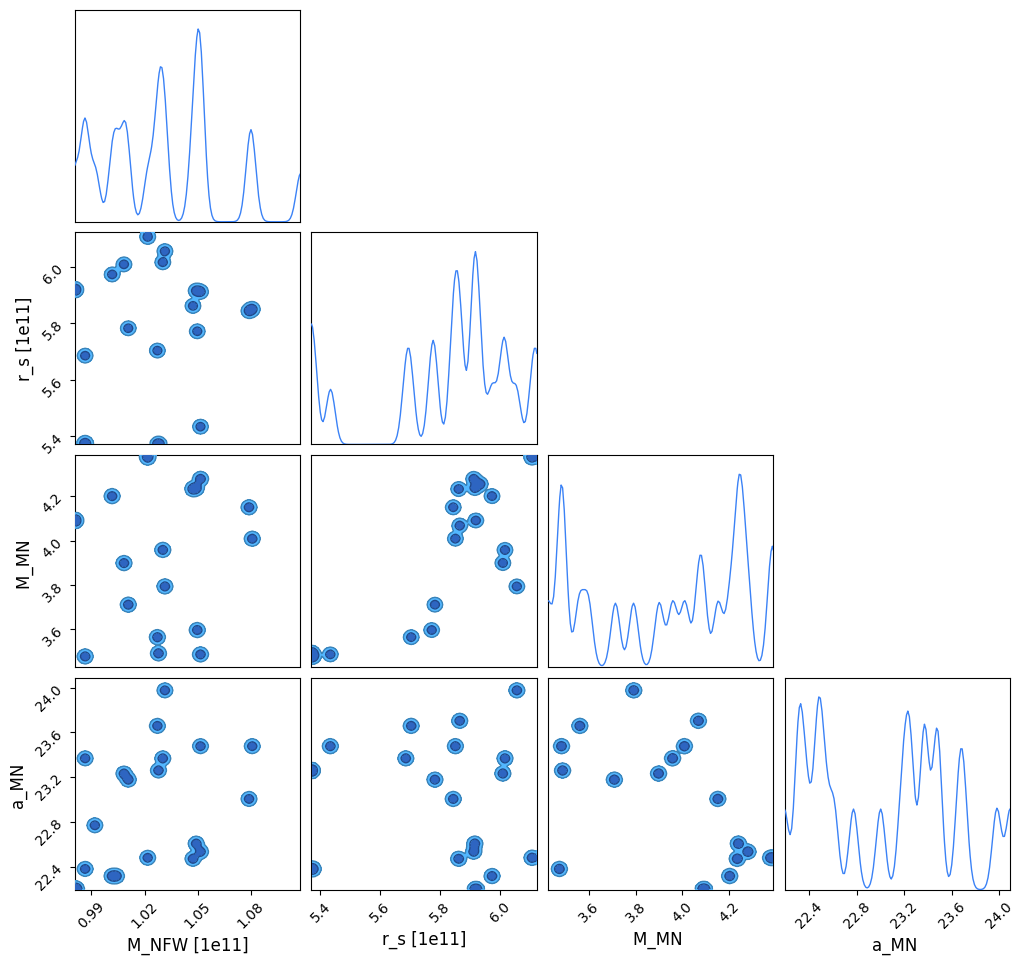


📊 MCMC Summary (filtered accepted samples):
Number of samples: 22
Number of chains: 1

Parameter estimates (mean ± std):
------------------------------------------------------------
$M_{MN}$ [M$_\odot$]: 1.026999e+11 ± 3.581121e+09
True value          : 6.819390e+10
Bias (σ)            : 9.64
------------------------------------------------------------
$M_{NFW}$ [M$_\odot$]: 5.811659e+11 ± 2.367214e+10
True value          : 4.368332e+11
Bias (σ)            : 6.10
------------------------------------------------------------
$M_{Plummer}$ [M$_\odot$]: 3.911419e+00 ± 3.445330e-01
True value          : 3.000000e+00
Bias (σ)            : 2.65
------------------------------------------------------------
$a_{MN}$ [kpc]      : 2.298238e+01 ± 6.357197e-01
True value          : 1.600000e+01
Bias (σ)            : 10.98
------------------------------------------------------------


IndexError: index 4 is out of bounds for axis 0 with size 4

In [30]:
def convert_to_dataframe_filtered(positions_dict, is_accepted_mask):
    """Convert dictionary of arrays to DataFrame, filtering by acceptance. Works for single or multiple chains."""
    
    # Handle both single chain and multi-chain cases
    if len(positions_dict['M_MN'].shape) == 1:
        # Single chain case: reshape to [1, num_samples]
        num_chains = 1
        num_samples = positions_dict['M_MN'].shape[0]
        
        # Reshape all arrays to add chain dimension
        positions_reshaped = {}
        for param_name, values in positions_dict.items():
            positions_reshaped[param_name] = values.reshape(1, -1)
        
        # Reshape acceptance mask
        is_accepted_reshaped = is_accepted_mask.reshape(1, -1)
        
    else:
        # Multi-chain case: use as-is
        num_chains = positions_dict['M_MN'].shape[0]
        num_samples = positions_dict['M_MN'].shape[1]
        positions_reshaped = positions_dict
        is_accepted_reshaped = is_accepted_mask
    
    print(f"Original samples: {num_chains} chains × {num_samples} samples = {num_chains * num_samples}")
    
    all_samples = []
    
    for chain_id in range(num_chains):
        # Get acceptance mask for this chain
        chain_accepted = is_accepted_reshaped[chain_id, :]  # Boolean mask for this chain
        
        # Extract samples for this chain
        chain_data = {}
        for param_name, values in positions_reshaped.items():
            # Only keep accepted samples
            chain_data[param_name] = values[chain_id, chain_accepted]
        
        # Count accepted samples for this chain
        n_accepted = jnp.sum(chain_accepted)
        print(f"  Chain {chain_id}: {n_accepted}/{num_samples} accepted ({n_accepted/num_samples*100:.1f}%)")
        
        # Create DataFrame for this chain (only accepted samples)
        if n_accepted > 0:  # Only add if there are accepted samples
            df_chain = pd.DataFrame(chain_data)
            df_chain['chain_id'] = chain_id
            df_chain['original_sample_id'] = jnp.where(chain_accepted)[0]  # Track original indices
            
            all_samples.append(df_chain)
    
    if not all_samples:
        print("⚠️ Warning: No accepted samples found!")
        return pd.DataFrame()
    
    # Combine all chains
    combined_df = pd.concat(all_samples, ignore_index=True)
    total_accepted = len(combined_df)
    total_original = num_chains * num_samples
    
    print(f"📊 Total accepted samples: {total_accepted}/{total_original} ({total_accepted/total_original*100:.1f}%)")
    
    return combined_df

# Usage remains the same - works for both single and multiple chains
positions = history_state[0].position
is_accepted = history_state[1].is_accepted

# Convert with filtering (now works for single chain too)
df_all_filtered = convert_to_dataframe_filtered(positions, is_accepted)

# Rest of the code remains exactly the same
burn_in = 10
thin_factor = 1  

if len(df_all_filtered) > 0:
    df_processed = df_all_filtered[
        (df_all_filtered['original_sample_id'] >= burn_in) & 
        (df_all_filtered['original_sample_id'] % thin_factor == 0)
    ].copy()
    
    # Remove metadata columns for plotting
    df_plot = df_processed.drop(['chain_id', 'original_sample_id'], axis=1)
    
    # Rename columns for nice LaTeX formatting
    df_plot.columns = ['M_NFW', 'r_s', 'M_MN', 'a_MN']
    
    print(f"📈 Final samples for plotting: {len(df_plot)}")
    
    # Create ChainConsumer plot with true values
    from chainconsumer import Chain, ChainConsumer, Truth
    
    # Create Chain object
    chain = Chain(samples=df_plot, name="MCMC Posterior (Filtered)")
    
    # Create ChainConsumer object
    c = ChainConsumer()
    c.add_chain(chain)
    
    # Add true values
    true_values_dict = {
        'M_MN': 68_193_902_782.346756,
        'M_NFW': 4.3683325e11,
        'a_MN': 3.0,
        'r_s': 16.0,
    }
    
    truth = Truth(location=true_values_dict, name="True Parameters")
    c.add_truth(truth)
    
    # Create corner plot
    print("🎨 Creating corner plot...")
    fig = c.plotter.plot()
    plt.show()
    
    # Print summary statistics
    print("\n📊 MCMC Summary (filtered accepted samples):")
    print(f"Number of samples: {len(df_plot)}")
    print(f"Number of chains: {df_processed['chain_id'].nunique()}")
    
    # Calculate parameter statistics
    param_names = ['$M_{MN}$ [M$_\odot$]', '$M_{NFW}$ [M$_\odot$]', '$M_{Plummer}$ [M$_\odot$]', '$a_{MN}$ [kpc]', '$a_{Plummer}$ [kpc]', '$r_s$ [kpc]', '$t_{end}$ [Gyr]']
    
    print("\nParameter estimates (mean ± std):")
    print("-" * 60)
    for i, param in enumerate(param_names):
        col_name = df_plot.columns[i]
        mean_val = df_plot[col_name].mean()
        std_val = df_plot[col_name].std()
        true_val = list(true_values_dict.values())[i]
        
        print(f"{param:20s}: {mean_val:.6e} ± {std_val:.6e}")
        print(f"{'True value':20s}: {true_val:.6e}")
        print(f"{'Bias (σ)':20s}: {(mean_val - true_val) / std_val:.2f}")
        print("-" * 60)
    
else:
    print("❌ No samples available for plotting after filtering!")